In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

In [3]:
mwig_df = pd.read_csv('mwig40.csv', parse_dates=['Data'])

In [5]:
mwig_df['day_change'] = ((mwig_df['Zamkniecie'] / mwig_df['Zamkniecie'].shift(1) ) - 1 ) * 100

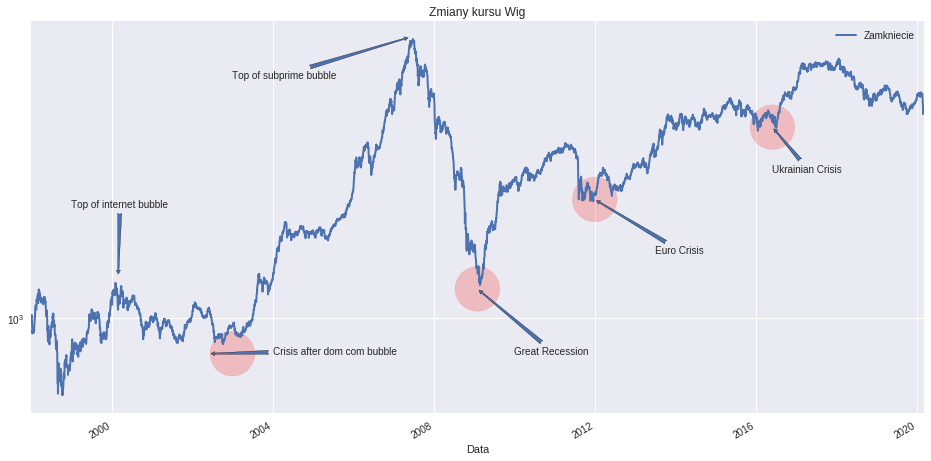

In [6]:
ax = plt.axes()

mwig_df.plot(x='Data', y='Zamkniecie', linewidth=2, figsize=[16, 8], ax=ax)

ax.set_title('Zmiany kursu Wig')
ax.set_yscale('log')

arrow_props = {'arrowstyle': 'fancy'}
annotates = [
    ['Top of internet bubble', [pd.Timestamp(2000, 3, 1),1300], [pd.Timestamp(1999, 1, 1), 2000]],
    ['Crisis after dom com bubble', [pd.Timestamp(2002, 6, 1), 800], [pd.Timestamp(2004,1,1), 800]],
    ['Top of subprime bubble', [pd.Timestamp(2007, 6, 1), 5800], [pd.Timestamp(2003, 1, 1), 4500]],
    ['Great Recession', [pd.Timestamp(2009, 2, 1), 1200], [pd.Timestamp(2010, 1, 1), 800]],
    ['Euro Crisis', [pd.Timestamp(2012, 1, 1), 2100], [pd.Timestamp(2013, 6, 30), 1500]],
    ['Ukrainian Crisis', [pd.Timestamp(2016, 6, 1), 3300], [pd.Timestamp(2016, 6, 1), 2500]]
]
for row in annotates:
    ax.annotate(row[0], xy=row[1], xytext=row[2], arrowprops=arrow_props)

extra_dots = np.array([
    [pd.Timestamp(2003, 1, 1), 800, 'red'],
    [pd.Timestamp(2009, 2, 1), 1200, 'red'],
    [pd.Timestamp(2012, 1, 1), 2100, 'red'],
    [pd.Timestamp(2016, 6, 1), 3300, 'red']
])
ax.scatter(extra_dots[:, 0], extra_dots[:,1], s=2000, alpha=0.2, c=extra_dots[:,2])

AttributeError: 'AxesSubplot' object has no attribute 'set_suptitle'

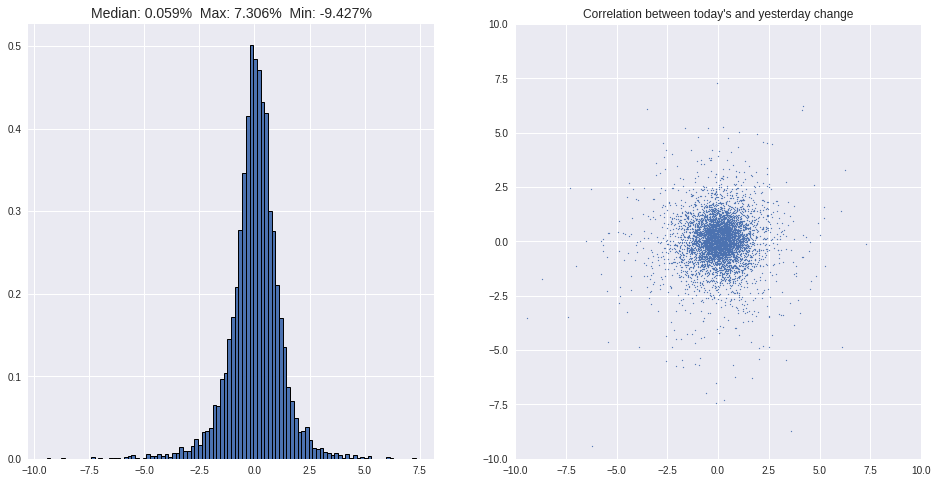

In [42]:
mediana = mwig_df['day_change'].median()
maximum = mwig_df['day_change'].max()
minimum = mwig_df['day_change'].min()
title = f'Median: {mediana:.3f}%  Max: {maximum:.3f}%  Min: {minimum:.3f}%'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 8])

mwig_df['day_change'].hist(bins=100, density=True, edgecolor='black', linewidth=1, ax=ax1)
ax1.set_title(title, fontsize=14)

mwig_df['day_ago_change'] = mwig_df['day_change'].shift()
ax2.scatter(mwig_df['day_change'], mwig_df['day_ago_change'].shift(), s=1)
title = f"Correlation between today's and yesterday change"
corr = mwig_df[['day_change', 'day_ago_change']].corr()
subtitle = f'Corr {corr.iloc[0,1]}'
ax2.set(xlim=(-10,10), ylim=(-10, 10), title=title)
ax2.set_suptitle(subtitle);

In [37]:
corr

,day_change,day_ago_change
day_change,1.000000,0.137658
day_ago_change,0.137658,1.000000


In [105]:
min_date = mwig_df['Data'].min()
max_date = mwig_df['Data'].max()

all_dates = pd.date_range(min_date, max_date, freq='D')
all_dates_df = pd.DataFrame({'Data': all_dates})
temp_df = pd.merge(all_dates_df, mwig_df, how='left', on='Data')
temp_df.fillna(method='ffill', inplace=True)
temp_df.dropna(inplace=True)
temp_df['1Y_change'] = ((temp_df['Zamkniecie'] / temp_df['Zamkniecie'].shift(365*1)) - 1) * 100
temp_df['PRED_1Y'] = ((temp_df['Zamkniecie'].shift(-365*5) / temp_df['Zamkniecie']) - 1) * 100

In [106]:
mwig_df_1Y = temp_df[temp_df['Data'].isin(mwig_df['Data'])].copy()
mwig_df_1Y.dropna(inplace=True)

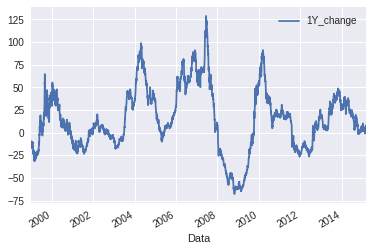

In [107]:
mwig_df_1Y.plot(x='Data', y='1Y_change');

In [108]:
tempor = mwig_df_1Y.copy()

,PRED_1Y,1Y_change
PRED_1Y,1.000000,-0.420737
1Y_change,-0.420737,1.000000


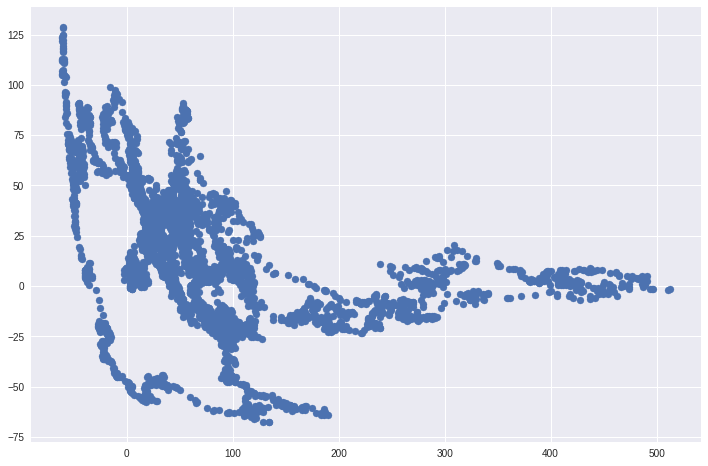

In [109]:
plt.figure(figsize=[12,8])
plt.scatter(tempor['PRED_1Y'], tempor['1Y_change'])
tempor[['PRED_1Y', '1Y_change']].corr()

In [112]:
tempor['LOW'] = 0
tempor.loc[tempor['1Y_change'] < 0, 'LOW'] = 1

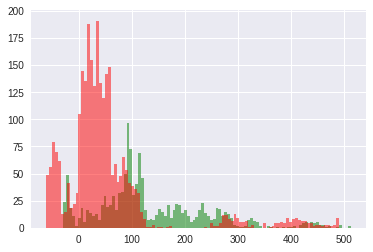

In [113]:
tempor.loc[tempor['LOW'] == 1, 'PRED_1Y'].hist(bins=100, color='green', alpha=0.5)
tempor.loc[tempor['LOW'] == 0, 'PRED_1Y'].hist(bins=100, color='red', alpha=0.5)

In [114]:
tempor.groupby('LOW')['PRED_1Y'].median()

LOW
0     34.198688
1    106.797259
Name: PRED_1Y, dtype: float64

In [115]:
from sklearn.ensemble import RandomForestRegressor

In [116]:
model = RandomForestRegressor()

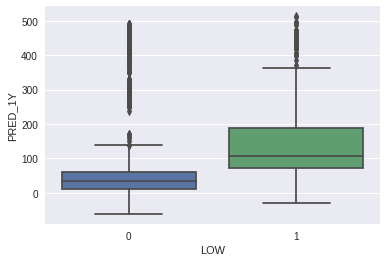

In [117]:
sns.boxplot(tempor['LOW'], tempor['PRED_1Y'])